In [1]:
#imports
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import array_to_latex
from qiskit.tools.monitor import job_monitor 
from qiskit.providers.ibmq import least_busy
from qiskit import *
from qiskit.visualization import *


from qiskit.providers.aer import QasmSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import numpy as np
from numpy import sum
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_501/1153469991.py:11: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [2]:
#constructing qiskit's calibration matrix
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)  
qc.measure([0, 1,2], [0, 1,2])

qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
backend = provider.get_backend('ibm_lagos')
t_qc = transpile(meas_calibs, backend, optimization_level=3)
job = backend.run(t_qc, shots=8000)
job_monitor(job, interval=2)

meas_fitter = CompleteMeasFitter(job.result(), state_labels, circlabel='mcal')
qiskitcalm= meas_fitter.cal_matrix

Job Status: job has successfully run


In [7]:
qiskitcalm= [[9.66750e-01, 1.37500e-02, 1.30000e-02, 1.25000e-04, 8.75000e-03, 1.25000e-04, 0.00000e+00, 0.00000e+00],
 [1.11250e-02, 9.71125e-01, 1.25000e-04, 1.12500e-02, 0.00000e+00, 8.50000e-03, 0.00000e+00, 0.00000e+00],
 [1.56250e-02, 1.25000e-04, 9.71750e-01, 1.23750e-02, 5.00000e-04, 0.00000e+00, 8.00000e-03, 2.50000e-04],
 [5.00000e-04, 1.01250e-02, 1.11250e-02, 9.71000e-01, 0.00000e+00, 7.50000e-04, 0.00000e+00, 9.12500e-03],
 [5.75000e-03, 0.00000e+00, 2.50000e-04, 0.00000e+00, 9.64000e-01, 1.32500e-02, 1.06250e-02, 6.25000e-04],
 [0.00000e+00, 4.87500e-03, 0.00000e+00, 1.25000e-04, 1.16250e-02, 9.68000e-01, 1.25000e-04, 1.46250e-02],
 [2.50000e-04, 0.00000e+00, 3.50000e-03, 0.00000e+00, 1.47500e-02, 2.50000e-04, 9.67750e-01, 1.31250e-02],
 [0.00000e+00, 0.00000e+00, 2.50000e-04, 5.12500e-03, 3.75000e-04, 9.12500e-03, 1.35000e-02, 9.62250e-01]]
print(qiskitcalm)

[[0.96675, 0.01375, 0.013, 0.000125, 0.00875, 0.000125, 0.0, 0.0], [0.011125, 0.971125, 0.000125, 0.01125, 0.0, 0.0085, 0.0, 0.0], [0.015625, 0.000125, 0.97175, 0.012375, 0.0005, 0.0, 0.008, 0.00025], [0.0005, 0.010125, 0.011125, 0.971, 0.0, 0.00075, 0.0, 0.009125], [0.00575, 0.0, 0.00025, 0.0, 0.964, 0.01325, 0.010625, 0.000625], [0.0, 0.004875, 0.0, 0.000125, 0.011625, 0.968, 0.000125, 0.014625], [0.00025, 0.0, 0.0035, 0.0, 0.01475, 0.00025, 0.96775, 0.013125], [0.0, 0.0, 0.00025, 0.005125, 0.000375, 0.009125, 0.0135, 0.96225]]


In [4]:
print("Qiskit's calibration matrix:")
array_to_latex(qiskitcalm)

Qiskit's calibration matrix:


<IPython.core.display.Latex object>

In [5]:
#sim code clement sent (thanks clement)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
provider.backends()

N = 2
epsilon = 0.5
mass = 1.0

def gauge_kinetic(epsilon):
    circuit=QuantumCircuit(1)
    circuit.rx(-epsilon/2,0)
    U_kg = circuit.to_gate()
    U_kg.name = "U$_{Kg}$"
    return U_kg

def fermion_mass(epsilon,mass,eta):
    circuit=QuantumCircuit(1)
    circuit.rz(-epsilon*mass * eta,0)
    U_m = circuit.to_gate()
    U_m.name = "U$_m$"
    return U_m

def fermion_hopping_opt2(epsilon,eta):
    circuit= QuantumCircuit(3)
    circuit.cx(0,2)
    circuit.h(0)
    circuit.cx(1,0)
    circuit.cx(0,2)
    circuit.rz(epsilon/4 * eta,0)
    circuit.rz(-epsilon/4 * eta,2)
    circuit.cx(0,2)
    circuit.cx(1,0)
    circuit.h(0)
    circuit.cx(0,2)
    U_fho2 = circuit.to_gate()
    U_fho2.name = "U$_{fho2}$"
    return U_fho2

def get_mean_fermion_number(counts):
    mean = 0
    values= list(counts.values())
    total_counts = sum(values)
    for s in counts:
        p = s[-1]
        if p == '1':
            mean = mean + (counts[s]/total_counts)
    return mean

def get_bootstrap_error(counts):
    values = list(counts.values())
    nshots=sum(values)
    nshots = int(np.round(nshots))
    B = 100
    k = list(counts.keys())
    prob = [counts[a]/nshots for a in k]
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=prob)
        for s in samples:
            p = s[-1]
            if p == '1':
                 m = m + (1/nshots)
        means.append(m)
    return np.std(means)

counts=[]
counts2=[]
noisymeans = []
mitigatedmeans = []
noisyerrs= []
mitigatederrs = []
Ts=[]

for T in range(int(0/epsilon),int(3/epsilon)):
    Ts.append(T)
    qc = QuantumCircuit(2*N-1, 2*N-1)

    qc.x(0)
    qc.h(0)

    for t in range(T):
        for n in range(0,2*N,2):
            qc.append(fermion_mass(epsilon,mass,(-1)**(n/2+1)),[n])
        for l in range(1,2*N-1,2):
            qc.append(gauge_kinetic(epsilon),[l])
        for n in range(0,2*N-3,2):
            qc.append(fermion_hopping_opt2(epsilon, (-1)**(n/2)),[n,n+1,n+2])
        
    qc.measure(range(3), range(3))
    backend = provider.get_backend('ibm_lagos')
    tc = transpile(qc, backend, optimization_level=3)
    job = backend.run(tc)
    noisy_results= job.result()
    counts.append(noisy_results.get_counts())
    
    meas_filter = meas_fitter.filter
    mitigated_results = meas_filter.apply(noisy_results)
    counts2.append(mitigated_results.get_counts())
    
    noisymeans.append(get_mean_fermion_number(counts[T]))  
    noisyerrs.append(get_bootstrap_error(counts[T]))
    mitigatedmeans.append(get_mean_fermion_number(counts2[T]))  
    mitigatederrs.append(get_bootstrap_error(counts2[T]))   

ibmqfactory.load_account:WARNING:2022-02-13 21:26:34,670: Credentials are already in use. The existing account in the session will be replaced.


In [8]:
counts = [{'000': 1817, '001': 2125, '010': 14, '011': 34, '100': 6, '101': 4}, {'000': 1860, '001': 1667, '010': 39, '011': 38, '100': 231, '101': 160, '110': 2, '111': 3}, {'000': 1622, '001': 1581, '010': 155, '011': 141, '100': 222, '101': 253, '110': 14, '111': 12}, {'000': 1474, '001': 1385, '010': 373, '011': 193, '100': 280, '101': 204, '110': 41, '111': 50}, {'000': 1476, '001': 1269, '010': 280, '011': 253, '100': 391, '101': 144, '110': 140, '111': 47}, {'000': 1307, '001': 1463, '010': 390, '011': 193, '100': 178, '101': 357, '110': 70, '111': 42}]
counts2 = [{'000': 1839.4472629135205, '001': 2158.1804770719204, '011': 2.37226001457859, '110': 5.53862511409875e-13, '111': 1.1241424457963944e-12}, {'000': 1897.4389358014416, '001': 1692.9824537159234, '010': 8.759688032306691, '011': 20.00670332366569, '100': 225.888589932297, '101': 153.76168720942292, '110': 5.78146119560164e-15, '111': 1.161941984942644}, {'000': 1651.1803324808948, '001': 1605.4257008349769, '010': 130.95035624874333, '011': 125.840566428573, '100': 216.84727976030172, '101': 250.51840331084722, '110': 10.072417416158242, '111': 9.164943519504991}, {'000': 1497.344169856423, '001': 1405.165442765123, '010': 356.86203518342876, '011': 178.64344018987606, '100': 278.26424864168143, '101': 199.56635634397833, '110': 35.73945573009694, '111': 48.41485128939213}, {'000': 1501.3855474673271, '001': 1285.4874059479575, '010': 259.40113120596743, '011': 242.88689717213134, '100': 393.1626496281274, '101': 136.84926591531183, '110': 136.71343598256286, '111': 44.11366668061461}, {'000': 1324.130293189327, '001': 1486.0857427156614, '010': 376.94104202147463, '011': 177.63167203000168, '100': 170.95433354305916, '101': 358.65572209976057, '110': 67.41102714162557, '111': 38.1901672590907}]
noisymeans = [0.54075, 0.46699999999999997, 0.49675, 0.458, 0.4282499999999999, 0.5137499999999999]
mitigatedmeans = [0.5401381842716223, 0.4669781965584887, 0.49773740352347545, 0.45794752264709254, 0.4273343089290038, 0.5151408260261285]
noisyerrs = [0.007996981852548242, 0.008171800214762062, 0.007457900173640569, 0.007476788665596193, 0.008097856197783802, 0.009187363604428721]
mitigatederrs = [0.007478261830130561, 0.006939172771302744, 0.00823220618971521, 0.007491051328083906, 0.007896696698619383, 0.007974026586360622]

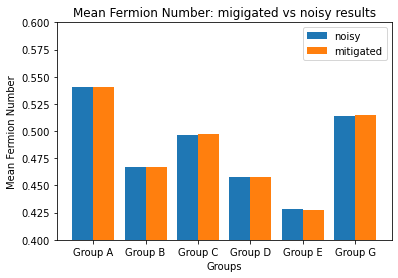

In [14]:
X = ['Group 1','Group 2','Group 3','Group 4', 'Group 5', 'Group 6']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisymeans, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatedmeans, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Mean Fermion Number")
plt.title("Mean Fermion Number: migigated vs noisy results")
plt.ylim([0.4, 0.6])
plt.legend()
plt.show()

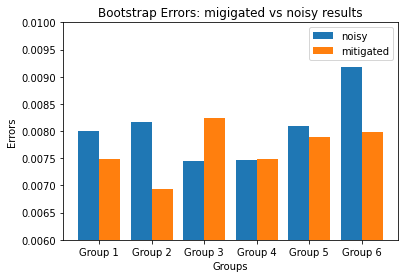

In [18]:
X = ['Group 1','Group 2','Group 3','Group 4', 'Group 5', 'Group 6']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisyerrs, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatederrs, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Errors")
plt.title("Bootstrap Errors: migigated vs noisy results")
plt.ylim([0.006, 0.01])
plt.legend()
plt.show()